# Day 19 - Tractor beam scanning

- https://adventofcode.com/2019/day/19

This starts as a simple intcode excercise; count the number of 1's in a 50x50 grid. The CPU programme halts after each coordinate, so we need to run the programme in a loop.


In [1]:
from __future__ import annotations

from itertools import product
from typing import List

import numpy as np
from IPython.display import display
from PIL import Image, ImageDraw

from intcode import CPU, ioset


def measure_signal(
    memory: List[int], scale=5, size=50, x: int = 0, y: int = 0
) -> np.array:
    image = Image.new("1", (size * scale, size * scale))
    draw = ImageDraw.Draw(image)
    dh = display(image, display_id=True)

    matrix = np.zeros((size, size), dtype=np.bool_)
    for yd, xd in product(range(size), repeat=2):
        xx, yy = x + xd, y + yd
        outputs, opcodes = ioset(xx, yy)
        CPU(opcodes).reset(memory).execute()
        value = outputs[0]

        draw.rectangle(
            (xd * scale, yd * scale, (xd + 1) * scale, (yd + 1) * scale), value
        )
        dh.update(image)
        matrix[yd, xd] = bool(value)

    return matrix

In [2]:
import aocd

data = aocd.get_data(day=19, year=2019)
memory = list(map(int, data.split(",")))

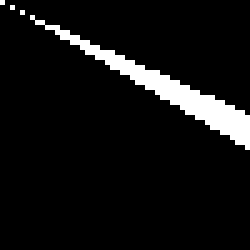

Part 1: 179


In [3]:
matrix = measure_signal(memory)
print("Part 1:", matrix.sum())

## Part 2 - Find where the beam is wide enough

Scanning a 50x50 area took long enough; finding that _really large area_ is going to taka a lot longer. Since the beam is widenining at a steady rate, we should be able to calculate where we'll be able to fit a 100x100 grid in the beam, however.

If the beam indeed widens at a constant rate, then the lines are simply two functions over y; both lines start at 0, so we only need to know the slopes $a$ and $b$:

$$
y_t(x) = ax \\
y_b(x) = bx
$$

The two slopes start at the same point, $(0, 0)$ and diverge. When the distance between this is $99 + (99 * a)$, then we can fit a 100 x 100 square in between, because that's the point fromhich the top line (with slope $a$) still has enough space to descend and accomodate the top right-hand corner.

So we can find the left-hand $x$ where $bx = ax + 99 + (99 * a)$, which can be simplified to:

$$
x = \frac{99(a + 1)}{a - b}
$$

We'll first need to determine the slopes $a$ and $b$ from the information the drone can give us. We can detect the transition from 0 to 1 and from 1 to zero at two separate $x$ coordinates for that, to give us the corresponding $y$ coordinates. Using numpy it's a simple subtraction of the shifted matrix; -1 markes the point from 0 -> 1 and 1 markes it from 1 -> 0. Then find the indices of the minimums (the -1 values), and the indices of the maximums. The latter are the point where it goes back into black, so the actual line needs 1 subtracted.

I've added a 'calibration' function that checks the values with the drone until we can predict the values exactly.


In [4]:
from fractions import Fraction
from itertools import count, groupby
from operator import itemgetter
from typing import Iterator, Tuple


def measure_x(memory: List[int], x: int, y_range: range) -> Iterator[int]:
    for y in y_range:
        outputs, opcodes = ioset(x, y)
        CPU(opcodes).reset(memory).execute()
        yield outputs[0]


def calibrate(
    memory: List[int], x: int, y: int, top: bool = True, tolerance: int = 5
) -> int:
    yr = range(y - tolerance, y + tolerance + 1)
    yc = next(
        next(yvs)[0]
        for v, yvs in groupby(
            enumerate(measure_x(memory, x, yr), yr.start), itemgetter(1)
        )
        if v == int(top)
    )
    return yc


def find_slopes(matrix: np.array, memory: List[int]) -> Tuple[Fraction, Fraction]:
    """Find the rate at which y declines over x, for the top and bottom lines"""
    matrix = matrix.view(np.int8)  # signed type to make sure we can get -1
    delta_yt = (matrix[1:, :] - matrix[:-1, :]).argmax(axis=0) + 1
    delta_yb = (matrix[1:, :] - matrix[:-1, :]).argmin(axis=0) + 1
    a, b = Fraction(delta_yt[-1], 49), Fraction(delta_yb[-1], 49)

    # calibrate by reading out larger values until a and b are stable
    for x1 in count(1000, 1000):
        yt1 = x1 * a.numerator // a.denominator
        ytc = calibrate(memory, x1, yt1)
        yb1 = (x1 * b.numerator // b.denominator) + 1
        ybc = calibrate(memory, x1, yb1, False)
        if yt1 == ytc and yb1 == ybc:
            return a, b
        a = Fraction(ytc, x1)
        b = Fraction(ybc, x1)


def find_fit(matrix: np.array, memory: List[int]) -> int:
    a, b = find_slopes(matrix, memory)
    xb = round((99 * (a + 1)) / (b - a))
    xt = xb + 99
    yt = xt * a.numerator // a.denominator
    return xb * 10000 + yt

In [5]:
print("Part 2:", find_fit(matrix, memory))

Part 2: 9760485
